<a href="https://colab.research.google.com/github/TuongHoangTy/Hybrid-Quantum-Classical-Parallel-Fusion-Architecture/blob/main/CNNClassicVsQuantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [2]:
!pip install pennylane torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 60.0 MB/s eta 0:00:00


Mounted at /content/drive
Device in use: cpu
Pre-existing results loaded successfully. Skipping trained models.


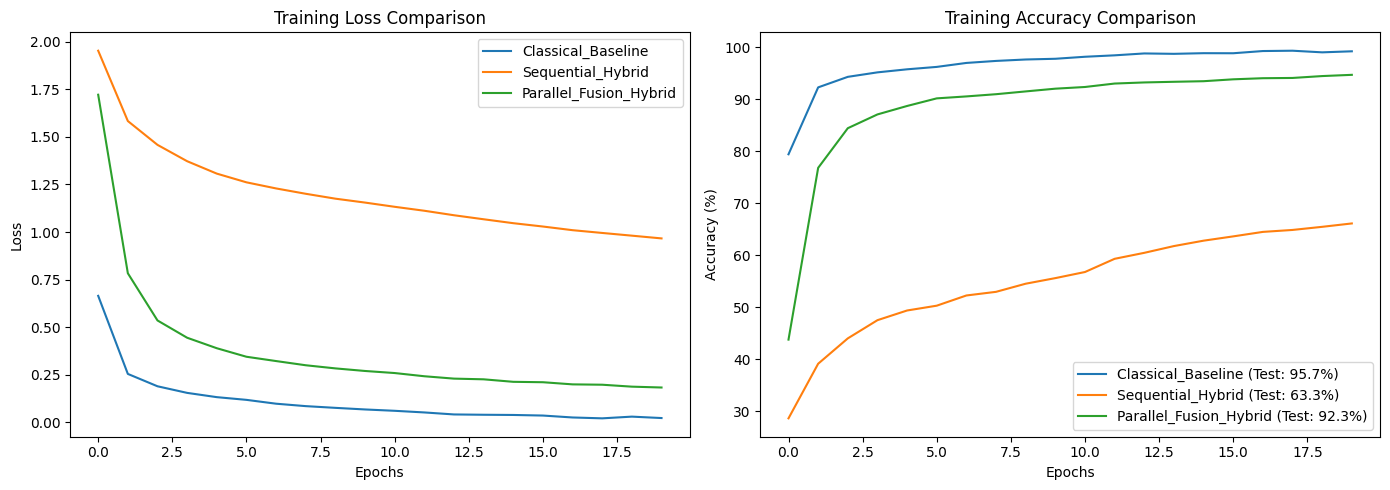

In [7]:
# ==========================================
# QUANTUM HYBRID MNIST - 2026 IMPROVED VERSION + CHECKPOINTING
# Updates: Multi-axis Angle Encoding, n_qubits=4, n_layers=2 (Barren Plateaus Mitigation)
# ==========================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pickle  # For saving final results

# ==========================================
# 1. Environment Configuration & Hyperparameters
# ==========================================
# Mount Google Drive for persistent storage
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ReseacherAboutQuantumComputer/2-Article'
DATA_PATH = os.path.join(BASE_PATH, 'Data')
MODEL_PATH = os.path.join(BASE_PATH, 'Models')

# Create directories if they do not exist
for path in [DATA_PATH, MODEL_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- HYPERPARAMETERS TUNED FOR THEORETICAL CLAIMS ---
n_qubits = 4          # Bottleneck compression: Decouples scaling law from image resolution
n_layers = 2          # Shallow circuit design: Mitigates Barren Plateaus (exponential gradient decay)
num_epochs = 20
batch_size = 16
print(f"Device in use: {device}")

# ==========================================
# 2. Quantum Circuit Definition (Using Angle Encoding)
# ==========================================
# Initialize PennyLane default simulator
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    Parametrized Quantum Circuit (VQC) serving as a Non-factorizable Feature Map.
    """
    # Step 1: Multi-axis Angle Encoding (Non-linear mapping to the Bloch sphere)
    # This preserves weak micro-features that classical ReLU/Max-Pooling might discard.
    for i in range(n_qubits):
        qml.RY(np.pi * inputs[i], wires=i)
        qml.RZ((np.pi / 2) * inputs[i], wires=i)

    # Step 2: Strongly Entangling Layers
    # Generates O(k) group-structured multiplicative interactions via Tensor Products.
    # Replaces O(d^k) classical Self-Attention mechanisms.
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # Step 3: Measurement
    # Returns the expected value of the Pauli-Z observable for each qubit.
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    """
    PyTorch wrapper for the PennyLane quantum circuit.
    """
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        # Initialize learnable parameters (weights) for the StronglyEntanglingLayers
        self.weights = nn.Parameter(0.01 * torch.randn(n_layers, n_qubits, 3))

    def forward(self, x):
        # Process the batch sequentially through the quantum circuit
        q_out = []
        for sample in x:
            res = quantum_circuit(sample, self.weights)
            q_out.append(torch.stack(res))
        return torch.stack(q_out).float().to(device)

# ==========================================
# 3. Model Architectures
# ==========================================
class ClassicalCNN(nn.Module):
    """Standard Convolutional Neural Network baseline."""
    def __init__(self):
        super(ClassicalCNN, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Flatten(), nn.Linear(32 * 4 * 4, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.main(x)

class SequentialHybridCNN(nn.Module):
    """Traditional sequential hybrid: Classical -> Quantum -> Output."""
    def __init__(self):
        super(SequentialHybridCNN, self).__init__()
        self.pre = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8, n_qubits), # Compress input to match n_qubits for Angle Encoding
            nn.Tanh()                 # Constrain values to [-1, 1] for stable rotation angles
        )
        self.q_layer = QuantumLayer(n_qubits, n_layers)
        self.post = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.pre(x)
        x = self.q_layer(x)
        return self.post(x)

class ParallelFusionHybridCNN(nn.Module):
    """
    Proposed Architecture: Parallel Fusion Hybrid QCNN (PF-HQCCNN)
    Operates classical and quantum branches in parallel to prevent data bottlenecks.
    """
    def __init__(self):
        super(ParallelFusionHybridCNN, self).__init__()
        # 1. Common Feature Extractor (Shared backbone)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # 2. Classical Branch (Learns local spatial invariance)
        self.classical_branch = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(32, 32)
        )

        # 3. Quantum Branch (Learns global phase-sensitive correlations)
        # Latent space bottleneck: Decouples scaling law (64px -> 4 qubits)
        self.q_compress = nn.Linear(8*8, n_qubits)
        self.q_layer = QuantumLayer(n_qubits, n_layers)

        # 4. Final Fusion Classifier
        self.classifier = nn.Linear(32 + n_qubits, 10)

    def forward(self, x):
        # Base extraction
        base = self.feature_extractor(x)

        # Classical feature extraction
        c_feat = self.classical_branch(base)

        # Quantum feature extraction (with preprocessing)
        q_raw = x.flatten(start_dim=1)
        # Tanh constrains the input phase angles to a mathematically stable range [-1, 1]
        q_input = torch.tanh(self.q_compress(q_raw))
        q_feat = self.q_layer(q_input)

        # Feature Fusion (Concatenation)
        combined = torch.cat((c_feat, q_feat), dim=1)
        return self.classifier(combined)

# ==========================================
# 4. Training Loop with Checkpointing System
# ==========================================
def run_experiment(model_class, name, train_loader, test_loader):
    """
    Trains the model with automatic state saving (checkpoints) to allow resuming
    in case of Colab runtime disconnections.
    """
    print(f"\n>>> Initializing Training: {name}")
    checkpoint_path = os.path.join(MODEL_PATH, f"{name}_checkpoint.pth")

    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    start_epoch = 0
    history = {'loss': [], 'acc': []}

    # Load checkpoint if it exists to resume training
    if os.path.exists(checkpoint_path):
        print(f"=> Found existing checkpoint. Resuming from: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        print(f"   Resuming at epoch {start_epoch}")

    # Training iterations
    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss, correct = 0.0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (out.argmax(1) == labels).sum().item()

        # Calculate metrics
        acc = 100 * correct / len(train_loader.dataset)
        avg_loss = train_loss / len(train_loader)
        history['loss'].append(avg_loss)
        history['acc'].append(acc)
        print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Train Acc={acc:.2f}%")

        # Save state after every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }, checkpoint_path)
        print(f"   Checkpoint saved for epoch {epoch+1}")

    # Final Evaluation on Test Set
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            test_correct += (model(imgs).argmax(1) == labels).sum().item()

    test_acc = 100 * test_correct / len(test_loader.dataset)
    print(f"=> {name} - Final Test Accuracy: {test_acc:.2f}%")

    return history, test_acc

# ==========================================
# 5. Data Preparation (MNIST Downsampled)
# ==========================================
# Downsample images to 8x8 to simulate edge device input and speed up VQC processing
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(DATA_PATH, train=True, download=True, transform=transform)
test_set = datasets.MNIST(DATA_PATH, train=False, download=True, transform=transform)

# Use subsets for faster prototyping (8000 train, 1000 test)
train_loader = DataLoader(Subset(train_set, range(8000)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(test_set, range(1000)), batch_size=batch_size)

# ==========================================
# 6. Execution & Result Serialization
# ==========================================
results = {}
results_path = os.path.join(MODEL_PATH, "final_results.pkl")

# Load previous results if available to skip retraining for visualization
if os.path.exists(results_path):
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print("Pre-existing results loaded successfully. Skipping trained models.")

models_to_run = [
    (ClassicalCNN, "Classical_Baseline"),
    (SequentialHybridCNN, "Sequential_Hybrid"),
    (ParallelFusionHybridCNN, "Parallel_Fusion_Hybrid")
]

# Run experiments for missing models
for m_class, name in models_to_run:
    if name not in results:
        results[name] = run_experiment(m_class, name, train_loader, test_loader)

# Serialize complete results
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

# ==========================================
# 7. Visualization (Training Dynamics)
# ==========================================
plt.figure(figsize=(14, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name][0]['loss'], label=name)
plt.title("Training Loss Comparison")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
for name in results:
    test_acc = results[name][1]
    plt.plot(results[name][0]['acc'], label=f"{name} (Test: {test_acc:.1f}%)")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)"); plt.legend()

plt.tight_layout()
plt.show()

Model Classical_Baseline: 71,754 trainable parameters.
Model Sequential_Hybrid: 334 trainable parameters.
Model Parallel_Fusion_Hybrid: 6,510 trainable parameters.


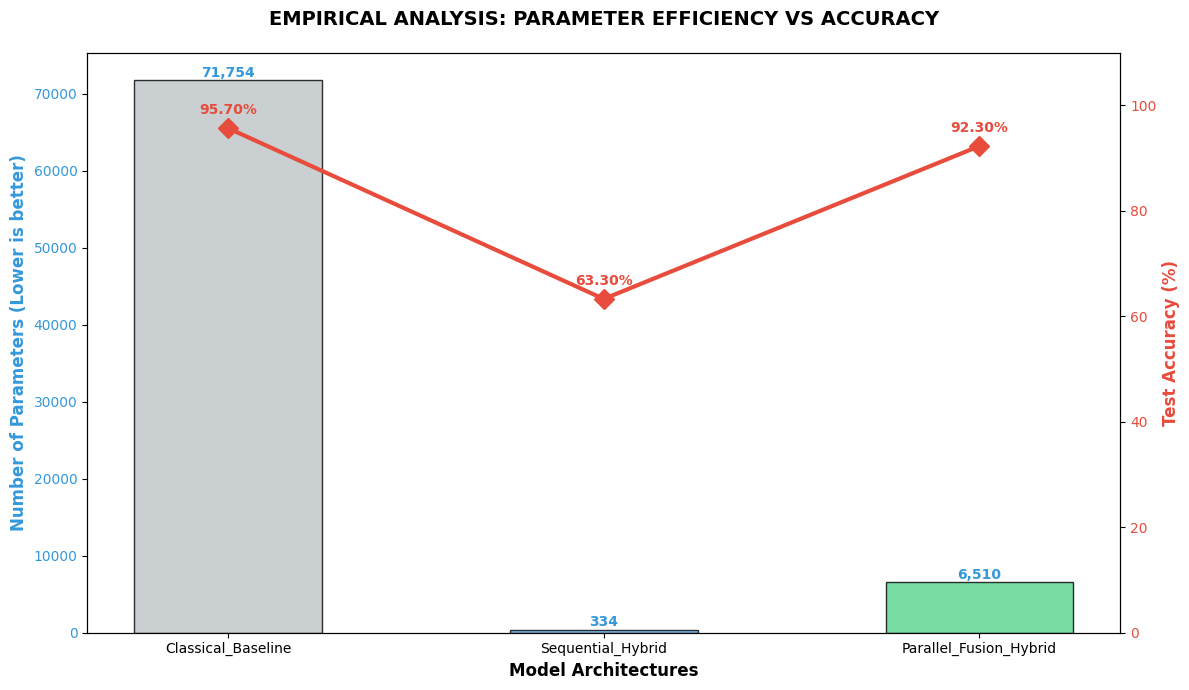

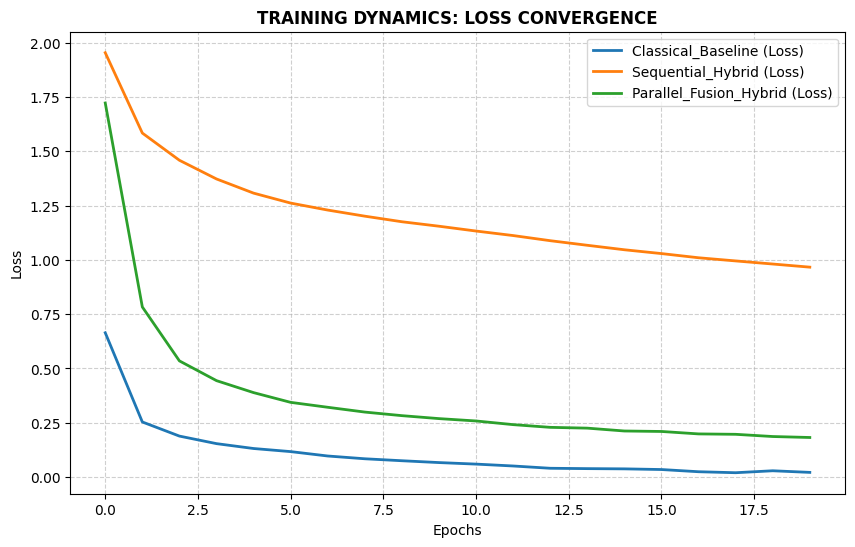

In [8]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

def get_model_parameters(model):
    """
    Calculates the exact number of trainable parameters for a given PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def visualize_scientific_results(results_dict, model_classes):
    """
    Automatically extracts empirical data from training results and generates
    scientific plots for parameter efficiency and training convergence.

    Args:
        results_dict: Dictionary containing training history and test accuracy.
        model_classes: List of model classes to instantiate and count parameters.
    """
    names = list(results_dict.keys())
    test_accuracies = [results_dict[name][1] for name in names]

    # 1. Calculate actual parameter counts dynamically (Avoids hardcoding)
    param_counts = []
    for m_class, name in model_classes: # Assuming models_to_run is passed or globally accessible
        temp_model = m_class()
        count = get_model_parameters(temp_model)
        param_counts.append(count)
        print(f"Model {name}: {count:,} trainable parameters.")

    # ==========================================
    # 2. Plot: Parameter Efficiency vs. Accuracy
    # ==========================================
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Bar chart for Parameter Count (Left Y-Axis)
    color_param = '#3498db'
    ax1.set_xlabel('Model Architectures', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Number of Parameters (Lower is better)', color=color_param, fontweight='bold', fontsize=12)

    # Render bars with distinct colors for visual separation
    bars = ax1.bar(names, param_counts, color=['#bdc3c7', '#5dade2', '#58d68d'], alpha=0.8, edgecolor='black', width=0.5)
    ax1.tick_params(axis='y', labelcolor=color_param)

    # Annotate parameter counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 100,
                 f'{int(height):,}', ha='center', va='bottom', fontweight='bold', color=color_param)

    # Line chart for Test Accuracy (Right Y-Axis)
    ax2 = ax1.twinx()
    color_acc = '#e74c3c'
    ax2.set_ylabel('Test Accuracy (%)', color=color_acc, fontweight='bold', fontsize=12)
    ax2.plot(names, test_accuracies, color=color_acc, marker='D', linewidth=3, markersize=10, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_acc)
    ax2.set_ylim(0, 110) # Set limit slightly above 100% for annotation padding

    # Annotate accuracy percentages on the line nodes
    for i, acc in enumerate(test_accuracies):
        ax2.annotate(f'{acc:.2f}%', (names[i], test_accuracies[i]),
                     textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold', color=color_acc)

    plt.title('EMPIRICAL ANALYSIS: PARAMETER EFFICIENCY VS ACCURACY', fontsize=14, fontweight='bold', pad=20)
    fig.tight_layout()

    # Save the figure for publication / GitHub repository
    plt.savefig(os.path.join(BASE_PATH, 'real_parameter_efficiency.png'), dpi=300)
    plt.show()

    # ==========================================
    # 3. Plot: Training Loss Convergence
    # ==========================================
    plt.figure(figsize=(10, 6))
    for name in names:
        plt.plot(results_dict[name][0]['loss'], label=f"{name} (Loss)", linewidth=2)

    plt.title('TRAINING DYNAMICS: LOSS CONVERGENCE', fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Save the convergence figure
    plt.savefig(os.path.join(BASE_PATH, 'real_loss_convergence.png'), dpi=300)
    plt.show()

# Execute the visualization function using the empirical 'results' dictionary
visualize_scientific_results(results, models_to_run)


PARAMETER REPORT AND IN-DEPTH EVALUATION
[Classical_Baseline] Total Trainable Parameters: 71,754
[Sequential_Hybrid] Total Trainable Parameters: 334
[Parallel_Fusion_Hybrid] Total Trainable Parameters: 6,510

--- Detailed Evaluation for Model: Parallel_Fusion_Hybrid ---
Classification Report:
              precision    recall  f1-score   support

           0     0.9326    0.9765    0.9540        85
           1     0.9841    0.9841    0.9841       126
           2     0.9123    0.8966    0.9043       116
           3     0.7846    0.9533    0.8608       107
           4     0.9623    0.9273    0.9444       110
           5     0.9865    0.8391    0.9068        87
           6     0.9419    0.9310    0.9364        87
           7     0.9565    0.8889    0.9215        99
           8     0.9390    0.8652    0.9006        89
           9     0.8812    0.9468    0.9128        94

    accuracy                         0.9230      1000
   macro avg     0.9281    0.9209    0.9226      1000
w

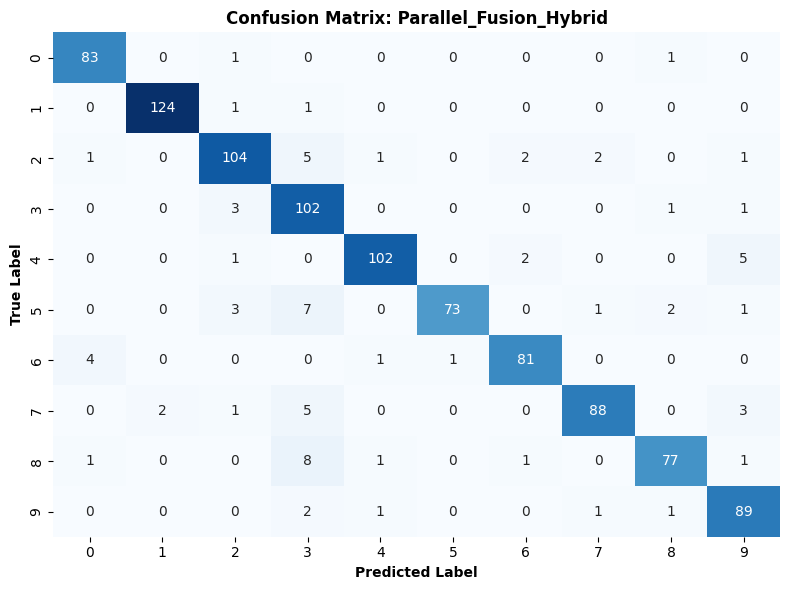

✓ Confusion matrix successfully saved to: /content/drive/MyDrive/ReseacherAboutQuantumComputer/2-Article/confusion_matrix_Parallel_Fusion_Hybrid.png


In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ==========================================
# 7. IN-DEPTH EVALUATION TOOLKIT
# ==========================================

def count_parameters(model, model_name):
    """
    Counts the total number of trainable parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[{model_name}] Total Trainable Parameters: {total_params:,}")
    return total_params

def evaluate_and_plot_confusion_matrix(model_class, model_name, test_loader):
    """
    Calculates the Precision, Recall, F1-Score and plots the Confusion Matrix.
    """
    print(f"\n--- Detailed Evaluation for Model: {model_name} ---")

    # 1. Load the best weights from the Checkpoint
    model = model_class().to(device)
    checkpoint_path = os.path.join(MODEL_PATH, f"{model_name}_checkpoint.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Checkpoint not found. Please ensure the model has been trained.")
        return

    model.eval()
    all_preds = []
    all_labels = []

    # 2. Perform predictions on the Test set
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 3. Print the Classification Report (Precision, Recall, F1-Score)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    # 4. Plot the Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))

    # Using a professional 'Blues' colormap to match academic standards
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[str(i) for i in range(10)],
                yticklabels=[str(i) for i in range(10)])

    plt.title(f'Confusion Matrix: {model_name}', fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    plt.tight_layout()

    # Save the figure to the specified path
    cm_path = os.path.join(BASE_PATH, f'confusion_matrix_{model_name}.png')
    plt.savefig(cm_path, dpi=300)
    plt.show()
    print(f"✓ Confusion matrix successfully saved to: {cm_path}")

# --- Execution of Evaluation ---
print("\n" + "="*50)
print("PARAMETER REPORT AND IN-DEPTH EVALUATION")
print("="*50)

# Count parameters for all baseline and proposed models
for m_class, name in models_to_run:
    temp_model = m_class()
    count_parameters(temp_model, name)

# Analyze Confusion Matrix specifically for the Proposed Model (Parallel Fusion)
evaluate_and_plot_confusion_matrix(ParallelFusionHybridCNN, "Parallel_Fusion_Hybrid", test_loader)